<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/blob/master/%5BPractice%5D_04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction


## Imports

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

## Download data

In [5]:
# ! wget -O /content/drive/MyDrive/Food_Classification/data_zip/10_food_classes_10_percent.zip https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

## Extract Data

In [6]:
# import zipfile

# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Food_Classification/data_zip/10_food_classes_10_percent.zip")
# zip_ref.extractall("/content/drive/MyDrive/Food_Classification/data/")
# zip_ref.close()

## Inspect data

In [7]:
# How many images in each folder?
import os

# Walk through the data directory
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in /content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/.
There are 10 directories and 0 images in /content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/test.
There are 0 directories and 250 images in /content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/test/ice_cream.
There are 0 directories and 250 images in /content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/test/chicken_curry.
There are 0 directories and 250 images in /content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/test/steak.
There are 0 directories and 250 images in /content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/test/sushi.
There are 0 directories and 250 images in /content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/test/chicken_wings.
There are 0 directories and 250 images in /content/drive/MyDrive/Food_Classification/data/10_foo

## Create data loaders (Preparing the data)
We will use `ImageDataGenerator` to load our images in batches.

In [8]:
# Setup data inputs

# Define paths
train_dir = "/content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/train"
test_dir = "/content/drive/MyDrive/Food_Classification/data/10_food_classes_10_percent/test"


# Define image shape and batch size
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

# Create data generators
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Load in data
print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')


test_data_10_percent = train_datagen.flow_from_directory(test_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [9]:
temp_x, temp_y = next(train_data_10_percent)
temp_x.shape

(32, 224, 224, 3)

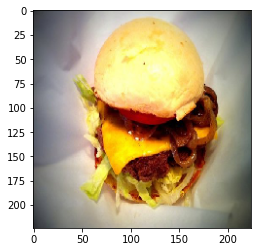

In [10]:
plt.imshow(temp_x[1])

## Setting up Callbacks
Callbacks are extra helpful functionalities you can add to your models to be performed during or after training. Some of the most popular ones are:  
1.  Tensorboard
2.  EarlyStopping
3.  ModelCheckpoint
4.  LearningRateScheduler


In [11]:
# Create TensorBoard callback (fuctionized because we need to create a new one for each experiment)
import datetime

def create_tensorboard(dir_name, experiment_name):
  """
  To create a new tensorboard callback for each new experiment.
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving tensorboard log files for {experiment_name} to {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In past we have used tensorflow to build a model layer by layer from scratch. But now we will use a prebuilt model.  

Browsing through `tensorflow hub` and finding good architecture for our problem using `paperswithcode` we decided to use `EfficientNet` for this project.

Let's compare the following two models:
1.  [EfficientNet](https://tfhub.dev/google/efficientnet/b0/feature-vector/1)
2.  [Resnet](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5)

  
[Details about EfficientNet architecture](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)

In [12]:
EFFICIENTNET_MODEL_URL = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'
RESNET_MODEL_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [13]:
IMAGE_SHAPE +(3,)

(224, 224, 3)

In [14]:
# Let's make a create_model()function to create model using a URL
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  -------------------------

  Args:
  model_url (str): A TensorFlow Hub feature extraction model URL.
  num_classes (int): Number of neurons in the output layer. 
                     Should be equal to number of target classes, default 10.
  --------------------------

  Return:
  returns an uncompiled keras sequential model with model_url as feature extractor layer 
  and dense output layer with num_classes output neurons.

  """

  # Download the pretrained model and save it as a keras layer
  feature_extraction_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # Freeze the weights learned using ImageNet
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,))
  
  # Create our Sequential model
  model = tf.keras.Sequential([
          feature_extraction_layer,
          tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])

  return model



### Creating and testing ResNet tensorflow hub feature extraction model

In [37]:
# Create Resnet model
resnet_model = create_model(RESNET_MODEL_URL,
                            num_classes = train_data_10_percent.num_classes)

In [38]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [39]:
# Compile our resnet model
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [40]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [41]:
resnet_history = resnet_model.fit(train_data_10_percent,
                  epochs = 5,
                  steps_per_epoch = len(train_data_10_percent),
                  validation_data = test_data_10_percent,
                  validation_steps=len(test_data_10_percent),
                  callbacks = [create_tensorboard(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                  experiment_name = 'resnet50V2'
                                                  )])

Saving tensorboard log files for resnet50V2 to /content/drive/MyDrive/Food_Classification/tensorboard/resnet50V2/20210526-134124
Epoch 1/5
24/24 [==============================] - 32s 1s/step - loss: 1.8486 - accuracy: 0.3867 - val_loss: 1.1099 - val_accuracy: 0.6572
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 0.8555 - accuracy: 0.7467 - val_loss: 0.8390 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.5881 - accuracy: 0.8440 - val_loss: 0.7348 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.4496 - accuracy: 0.8853 - val_loss: 0.7077 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3647 - accuracy: 0.9187 - val_loss: 0.6830 - val_accuracy: 0.7792


Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

In [47]:
 # Let's create a function to plot our loss curves...
 # If you wanted to, you could really turn this into a helper function to load in with a helper.py script...

# plot val and training curves
def plot_metrics_curves(history):
  """
  returns separate loss curves for traing and validation metrics
  Args:  
    history: Tensorflow history object
  
  Return:
    Plots training/validation loss and accuracy metrics.
  """

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['loss']))


  # Plot loss
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'validation_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curve')
  plt.legend()
  
  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'validation_accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curve')
  plt.legend()

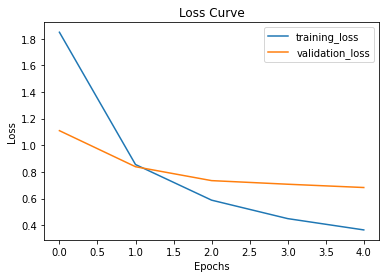

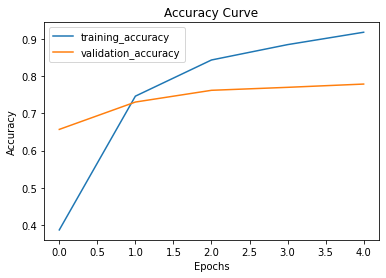

In [48]:
plot_metrics_curves(resnet_history)

### Creating and testing EfficientNet tensorflow hub feature extraction model

In [54]:
efficientnet_model = create_model(EFFICIENTNET_MODEL_URL,
                                  num_classes = train_data_10_percent.num_classes)

In [55]:
efficientnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

In [56]:
# Fit efficientnet model to 10% of data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                       epochs = 5,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data_10_percent,
                       validation_steps = len(test_data_10_percent),
                       callbacks = [create_tensorboard(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                      experiment_name = 'efficientnetb0'
                                                  )])

Saving tensorboard log files for efficientnetb0 to /content/drive/MyDrive/Food_Classification/tensorboard/efficientnetb0/20210526-135931
Epoch 1/5
24/24 [==============================] - 29s 1s/step - loss: 1.8926 - accuracy: 0.4107 - val_loss: 1.3143 - val_accuracy: 0.7264
Epoch 2/5
24/24 [==============================] - 23s 992ms/step - loss: 1.1046 - accuracy: 0.7560 - val_loss: 0.8769 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 23s 979ms/step - loss: 0.7755 - accuracy: 0.8280 - val_loss: 0.7035 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 23s 989ms/step - loss: 0.6186 - accuracy: 0.8613 - val_loss: 0.6129 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 23s 982ms/step - loss: 0.5243 - accuracy: 0.8840 - val_loss: 0.5584 - val_accuracy: 0.8636


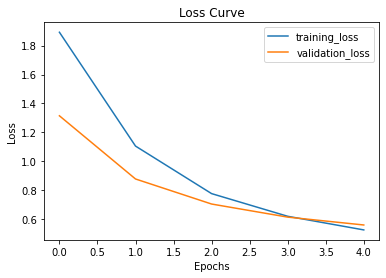

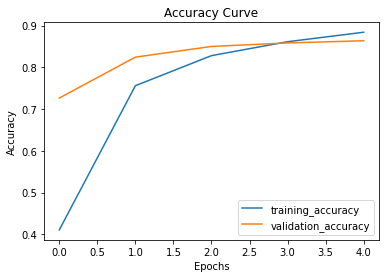

In [57]:
plot_metrics_curves(efficientnet_history)